## 1) Testing the DBSCAN algorithm on part of the dataset

[ 0  1  1  1  2  2  3  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  8  8
  8  9  9  9 10 10 10 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 14
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22
 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26
 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28]


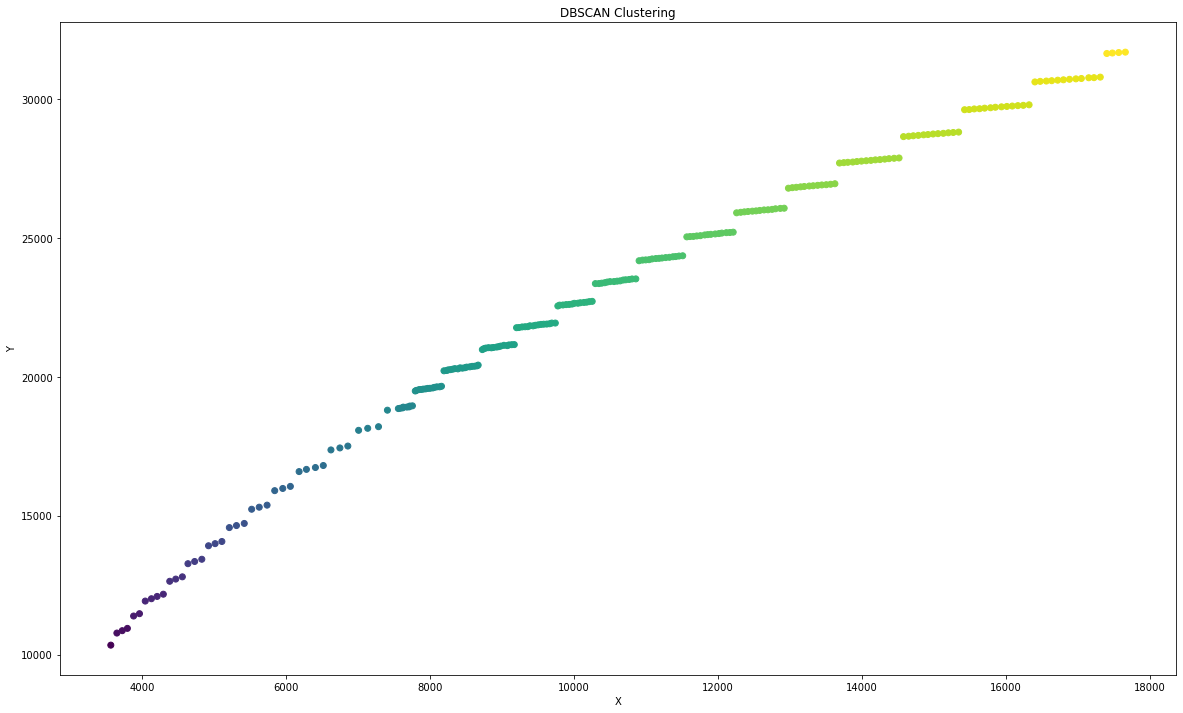

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import math

df = pd.read_csv('test_DBSCAN.csv')
X=np.array(df[['load', 'pressure']])
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=331, min_samples=1)
labels = dbscan.fit_predict(X)


# Plot the clusters
plt.figure(figsize=(20, 12))
plt.scatter(X[:, 0], X[:, 1], c=labels[:])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering')
print(labels[:])

In [6]:
X = df.drop(columns=['axial_pos', 'speed', 'angular_pos'])
# Difference column (Difference between 2 consecutive pressures)
X['difference'] = X['pressure'] - X['pressure'].shift(1)
# Taking absolute difference
X['difference'] = X['difference'].abs()
# Fill in nan with zeros
X['difference'] = X['difference'].fillna(0)
X

,load,pressure,difference
0,3567.88,10338.690157,0.000000
1,3652.39,10774.410263,435.720107
2,3726.90,10860.324187,85.913924
3,3798.46,10942.777259,82.453072
4,3884.64,11387.946679,445.169420
...,...,...,...
235,17315.70,30804.866964,19.385810
236,17406.60,31656.580880,851.713916
237,17483.90,31673.691337,17.110456
238,17572.30,31690.846930,17.155594


## 2) Linking epsilon to mean+std

281.0752765576012


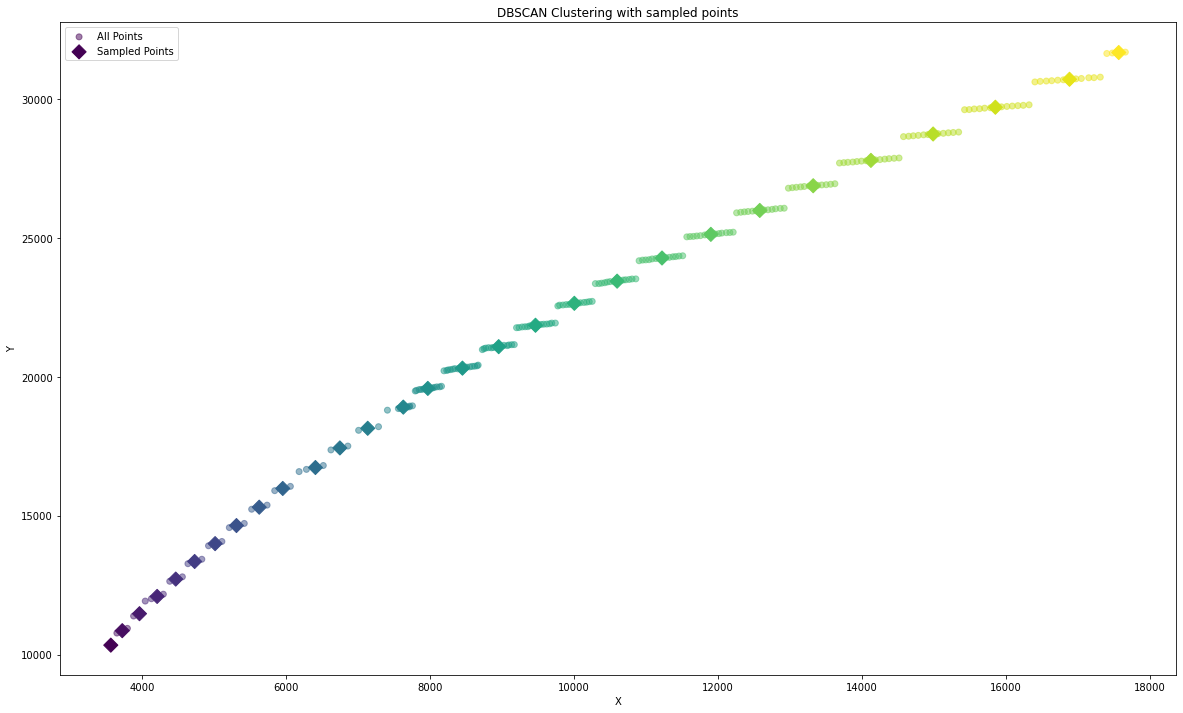

In [37]:
# Epsilon -> mean+std
eps = (X['difference'].mean()) + (X['difference'].std())
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=1)
labels = dbscan.fit_predict(X[['pressure', 'load']])

# Identify unique labels
unique_labels = np.unique(labels)

middle_indices = []

for label in unique_labels:
    label_indices = np.where(labels == label)[0]

    # Compute the middle index
    middle_index = label_indices[len(label_indices) // 2]
    middle_indices.append(middle_index)
median_points_array = np.array(middle_indices)
X_temp = X.drop(columns=['difference']).values
X_temp = X_temp[middle_indices]
        
# Plot the entire dataset
plt.figure(figsize=(20, 12))
plt.scatter(X.values[:, 0], X.values[:, 1], c=labels[:], alpha=0.5, label='All Points')

# Overlay the median points on top with a different marker and size
plt.scatter(X_temp[:, 0], X_temp[:, 1], c=unique_labels, marker='D', s=100, label='Sampled Points')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering with sampled points')
plt.legend()
plt.savefig("Images/DBSCAN_sampling_large_epsilon.png", dpi=300, bbox_inches='tight') 
plt.show()


## 3) Trying out the method on the whole dataset

In [8]:
import pandas as pd
df = pd.read_csv('journal_bearing.csv')
header = ['speed', 'eccentricity', 'load', 'axial_pos', 'angular_pos', 'thickness', 'pressure']
df.columns = header
# Choose values of eccentricity between 0.3, 0.7
df = df[df['eccentricity'].between(0.3, 0.7)]
# Remove the upcoming values that correspond to zero at any input
zero_pressure_condition = (df['angular_pos']<-2.7) | (df['angular_pos']>1.37)
df = df[~zero_pressure_condition]
df = df.drop(columns=['eccentricity', 'thickness'])
df


KeyboardInterrupt



### Adaptive DBSCAN

In [17]:
def reshape_df(df):
    reshaped_df = df.groupby(['speed', 'angular_pos', 'axial_pos']).agg({'load': list, 'pressure': list}).reset_index()
    reshaped_df = reshaped_df.explode(['load', 'pressure']).reset_index(drop=True)
    reshaped_df['difference'] = reshaped_df['pressure'] - reshaped_df['pressure'].shift(1)
    # Taking absolute difference
    reshaped_df['difference'] = reshaped_df['difference'].abs()
    # Fill in nan with zeros
    reshaped_df['difference'] = reshaped_df['difference'].fillna(0)
    reshaped_columns = list(df.columns) + ['difference']
    reshaped_df = reshaped_df.reindex(columns=reshaped_columns)
    return reshaped_df

def select_indices_load(df):
    """
    Retrieves the representitive indices. Supply the func with dataframe.
    
    Args:
        df (dataframe)

    Returns:
        Indices of representitive points along load dimension.
        
    Example:
        >>> select_indices_load(df)
        [3, 13, 23]
    """
    df_indices = np.array(df.index)
    data = np.array(df['difference'])  
    # Calculate the standard deviation and mean
    std_dev = np.std(data)
    mean = np.mean(data)
    # Threshold for defining a spike
    threshold_in_std = 1
    # Calculate modified z-scores using standard deviation
    mod_z_scores = np.abs(data - mean) / std_dev
    # Create a boolean flag list: True if the point is a spike, False otherwise
    spike_flags = mod_z_scores > threshold_in_std
    spike_flags = spike_flags.astype(int)
    # First and last element are marked as 1
    spike_flags[[0, -1]] = 1
    #print(sum(spike_flags))
    # If there are no spikes (normal graph) then sample some of the points in between
    # sum(spike_flags) is a threshold at which points are sampled uniformly. If bigger than the threshold -> Choosing points will be based on spikes
    # Also, if All pressure values equal to 0, then sample uniformly from the distribution
    if sum(spike_flags) <= 15 or (df['difference'].unique()[0]==0 and len(df['difference'].unique())==1):
        equal_separabale_indices = np.linspace(0, 239, num=24, dtype=int)
        ind = df.index
        # Extract the corresponding points from the array
        representitive_indices = ind[equal_separabale_indices]
    else:
         
        epsilon = mean + std_dev
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=epsilon, min_samples=1)
        pressures_loads = df[['pressure', 'load']].values
        labels = dbscan.fit_predict(pressures_loads)
        # Identify unique labels
        unique_labels = np.unique(labels)
        middle_indices = []
        for label in unique_labels:
            # indices of points with current label
            label_indices = np.where(labels == label)[0]
            # Compute the middle index (Sampled point)
            middle_index = label_indices[len(label_indices) // 2]
            middle_indices.append(middle_index)
        representitive_indices = df_indices[middle_indices]
    return representitive_indices


def reduce_dataset(df, reduction_dimension, method):
    """
    Reshapnig df for using in adaptive DBSCAN
    
    Args:
        df : Our reshaped dataframe (Full dataset)

    Returns:
        Indices of Chosen points.
        
    """
    if reduction_dimension=='axial_pos': return select_indices_axial(df)
    # Block step is chosen as 240 as this is the number of points insided a group shown in the graph
    block_step = 240
    blocks = int(df.shape[0]/block_step)
    count = 0
    chosen_indices = np.array([])
    for start_row in range(blocks):
        start = start_row*block_step
        end = start + block_step
        block_df = df[start:end]
        if method=='custom': 
            picked_indices = select_indices_load(block_df)
        elif method == 'custom_random':
            picked_indices = block_df.sample(n=24, random_state=42).index
        chosen_indices = np.concatenate((chosen_indices, picked_indices)).astype(int)
    return chosen_indices


In [18]:
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np

reshaped_df = reshape_df(df)

In [ ]:
reduced_indices_load = reduce_dataset(reshaped_df, "load", method='custom')
filtered_df = reshaped_df.iloc[reduced_indices_load].drop(columns = ['difference'])
filtered_df['load'] = filtered_df['load'].astype(float)
filtered_df['pressure'] = filtered_df['pressure'].astype(float)

### Run this cell multiple times to generate different features and visualize next on graph

In [39]:
random_angular = df['angular_pos'].sample().iloc[0]
random_speed = df['speed'].sample().iloc[0]
random_axial = df['axial_pos'].sample().iloc[0]

### Points in orange are the sampled points

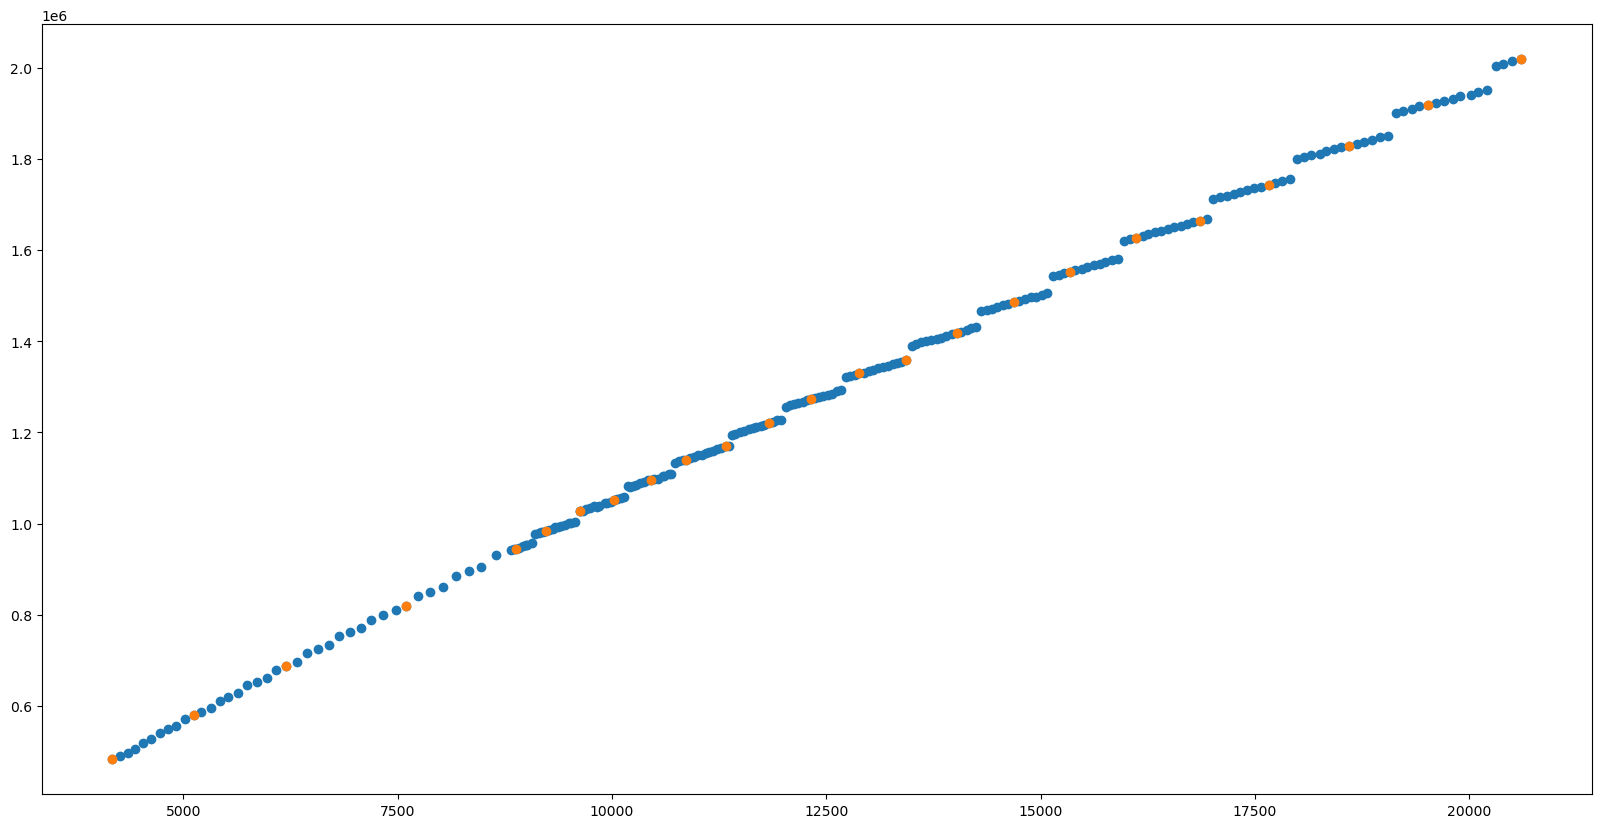

In [40]:
plt.figure(figsize=(20, 10))
test_cond = (df['angular_pos'] ==  random_angular) & (df['speed'] == random_speed) & (df['axial_pos'] == random_axial)
plt.scatter(data=df[test_cond], x='load', y='pressure')
test_cond2 = (filtered_df['angular_pos'] ==  random_angular) & (filtered_df['speed'] == random_speed) & (filtered_df['axial_pos'] == random_axial)
plt.scatter(data=filtered_df[test_cond2], x='load', y='pressure')
#plt.savefig("Images/DBSCAN_sampling_6.png", dpi=300, bbox_inches='tight') 
plt.show()

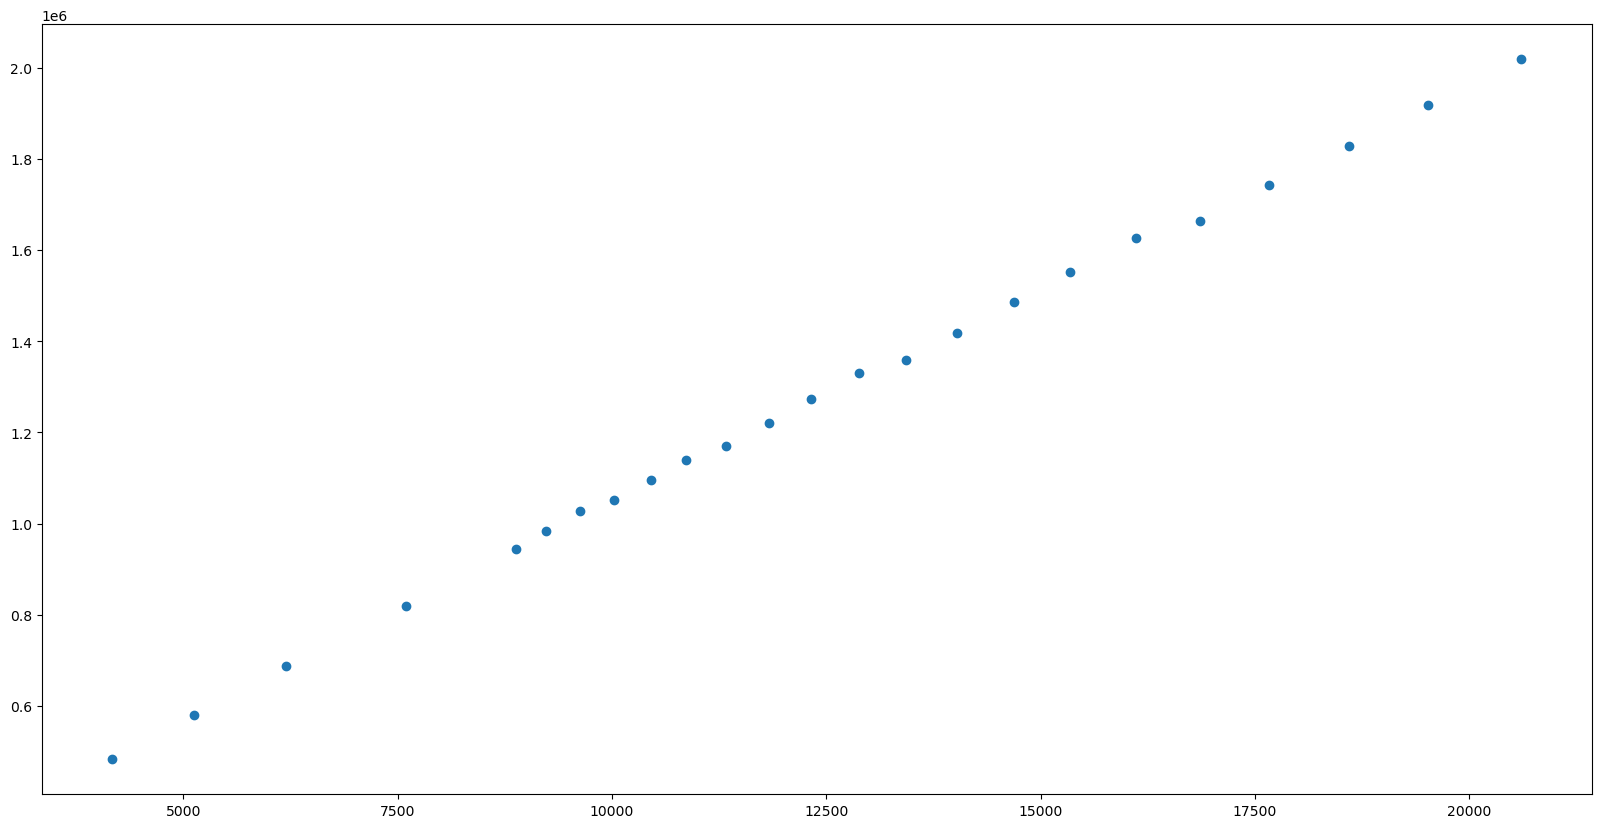

In [41]:
plt.figure(figsize=(20, 10))
test_cond = (filtered_df['angular_pos'] ==  random_angular) & (filtered_df['speed'] == random_speed) & (filtered_df['axial_pos'] == random_axial)
plt.scatter(data=filtered_df[test_cond], x='load', y='pressure')